In this notebook we are going to explore the performance of the InSAR4SM, which is an imporved methodology based on De Zan`s methodology, for several weighting factors of coherence in the inversion step.

In [1]:
#---------------------Import libraries --------------
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import os, pickle
import scipy.stats

#--------------------- INSAR4SM functionalities --------------
from insar4sm.classes import INSAR4SM_stack, SM_point
from insar4sm.gridding import WGS84_to_UTM

In [2]:
def create_buffer_poly(ISMN_station_file: str, grid_size: float, save: bool = True ) -> shapely.geometry.polygon.Polygon:

    # convert wgs geometry to projection system

    ISMN_station_loc_wgs84 = gpd.read_file(ISMN_station_file)
    ISMN_station_loc_wgs84.crs = "EPSG:4326"

    lon = ISMN_station_loc_wgs84['geometry'][0].x
    lat = ISMN_station_loc_wgs84['geometry'][0].y
    utm_crs_epsg = WGS84_to_UTM(lon, lat)    

    ISMN_station_loc_UTM = ISMN_station_loc_wgs84.to_crs(epsg=utm_crs_epsg).iloc[0].geometry

    ISMN_station_loc_UTM_buffer = ISMN_station_loc_UTM.buffer(grid_size, cap_style = 1)

    ISMN_station_loc_buffer = gpd.GeoDataFrame(index=[0], crs=utm_crs_epsg, geometry=[ISMN_station_loc_UTM_buffer])

    ISMN_station_loc_buffer = ISMN_station_loc_buffer.to_crs(epsg=4326)

    if save:
        save_dir = os.path.dirname(ISMN_station_file)
        filename = os.path.join(os.path.basename(ISMN_station_file).split('.')[0]+'_'+str(grid_size)+'.geojson')
        ISMN_station_loc_buffer.to_file(os.path.join(save_dir,filename), driver="GeoJSON")  

    return ISMN_station_loc_buffer.geometry

In [3]:
def run_INSAR4SM(orbit_num, orbit_time_UTC, grid_size, ISMN_station, driest_date, weight_factor):
    ###############################################################################
    # the name of your experiment
    projectname = 'INSAR4SM_r2_v2_orb{}_{}m_coh_weight_{}_{}'.format(orbit_num, grid_size, weight_factor, ISMN_station)

    # the directory of the topstack processing
    topstackDir = '/RSL02/SM_NA/Topstack_processing_orbit_{}'.format(orbit_num)

    # the AOI geojson file for your project
    # ensure that AOI is inside your topstack stack
    #AOI = '/RSL02/SM_NA/Plotting/bbox_aoi.geojson'
    AOI = '/RSL02/SM_NA/ISMN/{}/{}_AOI.geojson'.format(ISMN_station,ISMN_station)

    # the meteorological file. You can either provide an ERA5-land file or a csv file with 3 columns (Datetimes, tp__m, skt__K).
    meteo_file = '/RSL02/SM_NA/era5/era5_land_na_orbit_{}.nc'.format(orbit_num)
    # set to True in case you provide an ERA5-Land file
    ERA5_flag = True
    # In case you downloaded surface soil moisture from ERA5-land, set to True for comparison purposes
    ERA5_sm_flag = True

    # the output directory 
    export_dir = '/RSL02/SM_NA/coh_weight_test/{}'.format(projectname)

    # soil information datasets (https://soilgrids.org/)
    if ISMN_station == 'FordDryLake':
        sand_soilgrids = 87
        clay_soilgrids = 13
    elif ISMN_station == 'DesertCenter':
        sand_soilgrids = 79
        clay_soilgrids = 11
    else:
        print('We dont have sand and clay info for the requested location')

    # the insitu measurements in csv format
    ISMN_csv = '/RSL02/SM_NA/ISMN/{}/ismn_station_{}.csv'.format(ISMN_station, ISMN_station)

    # geometrical infromation regarding ISMN station

    ISMN_station_loc = '/RSL02/SM_NA/ISMN/{}/{}_location.geojson'.format(ISMN_station,ISMN_station)


    #IMSN_polygon = gpd.read_file('/RSL02/SM_NA/ISMN/{}/{}_neighborhood.geojson'.format(station_name, station_name))['geometry']

    IMSN_polygon = create_buffer_poly(ISMN_station_loc, grid_size )

    ISMN_point = IMSN_polygon.centroid

    stack = INSAR4SM_stack(topstackDir = topstackDir,
                        projectname = projectname,
                        AOI = AOI,
                        meteo_file = meteo_file,
                        ERA5_flag = ERA5_flag,
                        sand = sand_soilgrids,
                        clay = clay_soilgrids,
                        orbit_time = orbit_time_UTC,
                        export_dir = export_dir)

    stack.prepare_datasets()
    stack.plot()
    stack.get_dry_SARs()
    stack.calc_insar_stack()

    stack.sm_points = ISMN_point
    stack.sm_polygons = IMSN_polygon
    stack.n_sm_points = len(stack.sm_points)

    sm_point_ts = SM_point(stack, sm_ind=0)
    sm_point_ts.weight_factor = weight_factor
    sm_point_ts.get_DS_info(stack)
    sm_point_ts.calc_covar_matrix()
    sm_point_ts.get_DS_geometry(stack)

    sm_point_ts.calc_driest_date()
    sm_point_ts.driest_date = pd.to_datetime(driest_date)
    sm_point_ts.calc_sm_sorting()

    # in_situ_data = pd.read_csv('/RSL02/SM_NA/comparison_FordDryLake.csv')
    # print(in_situ_data['sm_plot'].loc[sm_point_ts.best_sorting])
    sm_point_ts.calc_sm_coherence()
    sm_point_ts.calc_sm_index()
    sm_point_ts.inversion()


    IMSN_df = pd.read_csv(ISMN_csv)
    IMSN_df.index = pd.to_datetime(IMSN_df['Datetime'])
    IMSN_df = IMSN_df['sm_plot']
    # select only particular hour

    IMSN_df = IMSN_df.at_time(orbit_time_UTC).to_frame()

    #insar4sm_df = pd.DataFrame(np.ones_like(sm_point_ts.best_sorting), columns=['insar4sm'])
    sm_estimations = {'SM0':sm_point_ts.SM0,
                    'SM_index':sm_point_ts.SM_index,
                    'insar4sm':sm_point_ts.sm_inverted
                    }

    insar4sm_df = pd.DataFrame(sm_estimations)
    insar4sm_df.index = pd.to_datetime(stack.slc_datetimes)
    insar4sm_df.index = insar4sm_df.index + pd.Timedelta('{} hour'.format(pd.to_datetime(orbit_time_UTC).hour))

    comparison_df = IMSN_df.join(insar4sm_df, how='outer').dropna()
    comparison_df['Datetime'] = comparison_df.index
    comparison_df.to_csv('{}/comparison_{}.csv'.format(stack.export_dir,ISMN_station), index=False)

    predictions = comparison_df['insar4sm'].values
    targets = comparison_df['sm_plot'].values
    n = predictions.shape[0]
    rmse = np.linalg.norm(predictions - targets) / np.sqrt(n)
    r, p = scipy.stats.pearsonr(predictions, targets)

    comparison_df[['sm_plot', 'insar4sm']].plot(figsize=(10,8), style='.-', ylim=(0,20))
    plt.title('RMSE: {} m3/m3 \n R : {}'.format(round(rmse,2), round(r,2)))

    plt.savefig('/RSL02/SM_NA/coh_weight_test/plots/{}.svg'.format(projectname))
    
    return r, rmse

In [ ]:
# different spatial resolutions (radius) 
grid_size_range = [100,125,150] 

# Station name | orbit number | hour (UTC) of SAR acquisitions | driest date
station_orbit_combs = [['DesertCenter','173','14:00:00','20180704'],
                       ['FordDryLake','173','14:00:00','20180704'],
                       ['FordDryLake','100','14:00:00','20180723'],
                       ['FordDryLake','166','02:00:00','20180722'],
                       ['DesertCenter','166','02:00:00','20180710']]

# Different coherence weights
coh_weight_range = range(1,10)

coh_df = pd.DataFrame()
for grid_size in grid_size_range:
    for coh_weight in coh_weight_range:
        for station_orbit_comb in station_orbit_combs:
            ISMN_station, orbit_num,  orbit_time_UTC, driest_date =  station_orbit_comb
            r_temp, rmse_temp = run_INSAR4SM(orbit_num, orbit_time_UTC, grid_size, ISMN_station, driest_date, coh_weight)

            row_df = {'ISMN_station': ISMN_station,
                    'coh_weight':coh_weight,
                    'orbit_num':orbit_num,
                    'grid_size': grid_size,
                    'r': r_temp,
                    'rmse': rmse_temp}
            
            coh_df = pd.concat([coh_df,pd.DataFrame([row_df])])

coh_df.to_csv('/RSL02/SM_NA/coh_weight_test/coh_weight_results.csv')

In [8]:
mean_performance = coh_df.groupby(['coh_weight']).mean()[['r','rmse']]

Text(0.5, 1.0, 'Mean R for different coherence weights for \n two ISMN stations for 3 orbit tracks for spatial resolutions (200, 250, 300)')

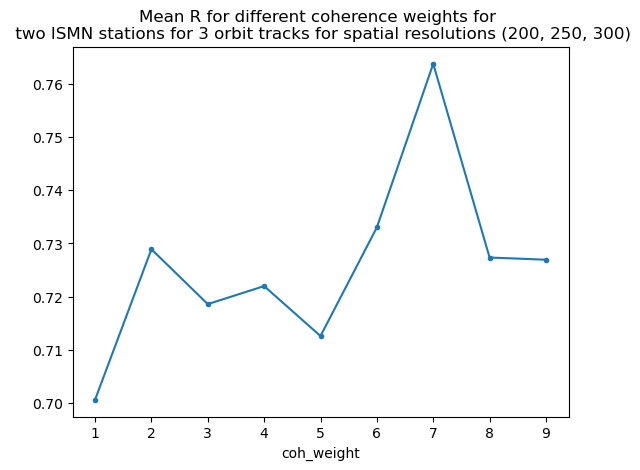

In [17]:
mean_performance['r'].plot(style='.-')
plt.title('Mean R for different coherence weights for \n two ISMN stations for 3 orbit tracks for spatial resolutions (200, 250, 300)')

Text(0.5, 1.0, 'Mean RMSE for different coherence weights \n two ISMN stations for 3 orbit tracks for spatial resolutions (200, 250, 300)')

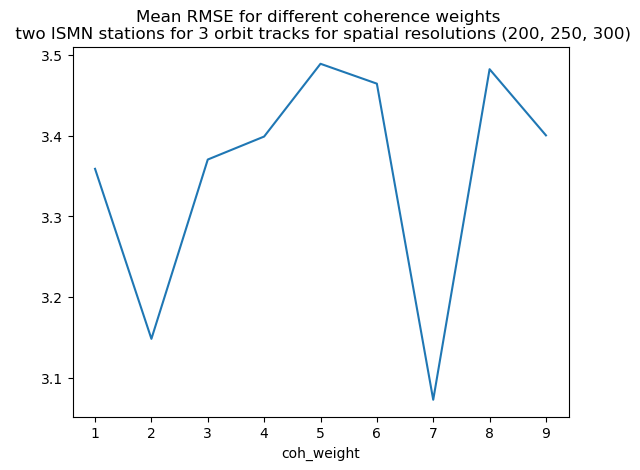

In [20]:
mean_performance['rmse'].plot()
plt.title('Mean RMSE for different coherence weights \n two ISMN stations for 3 orbit tracks for spatial resolutions (200, 250, 300)')